[Starter code used](https://www.kaggle.com/rsmits/keras-efficientnet-b3-training-inference)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import tensorflow as tf
import keras
from keras.models import Model, Input
from keras.layers import Input, Dense, Lambda
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint

import cv2 
from math import ceil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Iterative-Stratification
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Using TensorFlow backend.


In [2]:
# Constants
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

HEIGHT = 137
WIDTH = 236
HEIGHT_NEW = 128
WIDTH_NEW = 128
CHANNELS = 3

BATCH_SIZE = 32 
TRAIN_DIR = '.'
TEST_SIZE = 1./8
EPOCHS = 2

RUN_NAME = 'Train1_'
PLOT_NAME1 = 'Train1_LossAndAccuracy.png'
PLOT_NAME2 = 'Train1_Recall.png'

In [3]:
def plot_summaries(history, plot_name1, plot_name2):
    # Plot loss and Accuracy 
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    df = pd.DataFrame(history)

    ax[0].plot(df[['root_loss','vowel_loss','consonant_loss', 'val_root_loss','val_vowel_loss','val_consonant_loss']])
    ax[0].set_ylim(0, 2)
    ax[0].set_title('Loss')
    ax[0].legend(['train_root_loss','train_vowel_loss','train_conso_loss', 'val_root_loss','val_vowel_loss','val_conso_loss'],
                loc='upper right')
    ax[0].grid()
    ax[1].plot(df[['root_accuracy','vowel_accuracy','consonant_accuracy', 'val_root_accuracy','val_vowel_accuracy','val_consonant_accuracy']])
    ax[1].set_ylim(0.5, 1)
    ax[1].set_title('Accuracy')
    ax[1].legend(['train_root_acc','train_vowel_acc','train_conso_acc', 'val_root_acc','val_vowel_acc','val_conso_acc'],
                loc='lower right')
    ax[1].grid()
    fig.savefig(plot_name1)

    # Plot Recall 
    fig, ax = plt.subplots(1, 1, figsize = (16, 16))
    df['total_recall'] = (2 * df['root_recall'] + df['vowel_recall_1'] + df['consonant_recall_2']) / 4
    df['val_total_recall'] = (2 * df['val_root_recall'] + df['val_vowel_recall_1'] + df['val_consonant_recall_2']) / 4
    ax.plot(df[['total_recall', 'root_recall','vowel_recall_1','consonant_recall_2', 'val_total_recall', 'val_root_recall','val_vowel_recall_1','val_consonant_recall_2']])
    ax.set_ylim(0.5, 1)
    ax.set_title('Recall')
    ax.legend(['total_recall', 'train_root_recall', 'train_vowel_recall', 'train_conso_recall', 'val_total_recall', 'val_root_recall','val_vowel_recall','val_conso_recall'],
                loc='lower right')
    ax.grid()
    fig.savefig(plot_name2)

# **Image Preprocessing**

[ROI resize](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)

In [4]:
def resize_roi(image, size=128):
    resized = {}
    resize_size=size
    
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = image[ymin:ymax,xmin:xmax]
    resized_roi = cv2.resize(roi, (resize_size, resize_size), interpolation=cv2.INTER_AREA)

    return resized_roi

# Image Prep
def resize_image(img, WIDTH_NEW, HEIGHT_NEW):
    # Invert
    img = 255 - img

    # Normalize
    img = (img * (255.0 / img.max())).astype(np.uint8)

    # Reshape
    img = img.reshape(HEIGHT, WIDTH)
    img = resize_roi(img)

    return img

def resize_and_save_image(train_dir, img, WIDTH_NEW, HEIGHT_NEW, image_id):
    # Resize Image
    image_resized = resize_image(img, WIDTH_NEW, HEIGHT_NEW)
    
    # Save Image
    cv2.imwrite(train_dir + str(image_id) + '.png', image_resized)

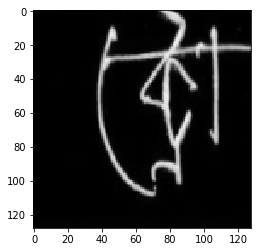

In [5]:
# Feather dir
featherdir = '/kaggle/input/bengaliaicv19feather'

# Loop through train Feather files (X)
first = True
for i in tqdm(range(0, 4)):

    df = pd.read_feather(featherdir+'/train_image_data_'+str(i)+'.feather')
    
    # Get Image Id values
    image_ids = df['image_id'].values 
    # Drop Image_id column
    df = df.drop(['image_id'], axis = 1)

    # Loop over rows in Dataframe and generate images 
    for image_id, index in zip(image_ids, range(df.shape[0])):
        resize_and_save_image(TRAIN_DIR,df.loc[df.index[index]].values, WIDTH_NEW, HEIGHT_NEW, image_id)
        if first:
            img = cv2.imread(TRAIN_DIR+str(image_id)+'.png')
            plt.imshow(img)
            plt.show()
            first = False

    # Cleanup
    del df
    gc.collect()

# **Model Definition**

In [6]:
# Generalized mean pool - GeM
gm_exp = tf.Variable(3.0, dtype = tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

def create_model(input_shape):
    # Input Layer
    input_tensor = Input(shape = input_shape)
    
    # Create and Compile Model and show Summary
    x_model = keras.applications.nasnet.NASNetMobile(input_tensor=input_tensor, include_top=False, weights='imagenet', pooling=None, classes=None)
    
    # UnFreeze all layers
    for layer in x_model.layers:
        layer.trainable = True
    
    # GeM
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    x = lambda_layer(x_model.output)
    
    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name = 'root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name = 'vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name = 'consonant')(x)

    # model
    model = Model(inputs = x_model.input, outputs = [grapheme_root, vowel_diacritic, consonant_diacritic])

    return model

# **Training**

In [7]:
# Prepare Train Labels (Y)
train_df = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
tgt_cols = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
desc_df = train_df[tgt_cols].astype('str').describe()
types = desc_df.loc['unique',:]
X_train = train_df['image_id'].values
train_df = train_df[tgt_cols].astype('uint8')
for col in tgt_cols:
    train_df[col] = train_df[col].map('{:03}'.format)
Y_train = pd.get_dummies(train_df)

# Cleanup
del train_df
gc.collect()

3

In [8]:
# Modelcheckpoint
def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = False, 
                            save_weights_only = True, 
                            mode = 'min', 
                            period = 1)


def _read(path):
    img = cv2.imread(path)    
    return img

In [9]:
model = create_model((HEIGHT_NEW, WIDTH_NEW, CHANNELS))
# Compile Model
model.compile(optimizer = Adam(lr = 0.00015),
                loss = {'root': 'categorical_crossentropy',
                        'vowel': 'categorical_crossentropy',
                        'consonant': 'categorical_crossentropy'},
                loss_weights = {'root': 0.40,        
                                'vowel': 0.30,
                                'consonant': 0.30},
                metrics = {'root': ['accuracy', tf.keras.metrics.Recall()],
                            'vowel': ['accuracy', tf.keras.metrics.Recall()],
                            'consonant': ['accuracy', tf.keras.metrics.Recall()] })

# Model Summary
print(model.summary())

19996672/19993432 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 63, 63, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           stem_bn1[0][0]                   
___________________________

In [10]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, X_set, Y_set, ids, batch_size = 16, img_size = (512, 512, 3), img_dir = TRAIN_DIR, *args, **kwargs):
        self.X = X_set
        self.ids = ids
        self.Y = Y_set
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

        # Split Data
        self.x_indexed = self.X[self.ids]
        self.y_indexed = self.Y.iloc[self.ids]

        # Prep Y per Label   
        self.y_root = self.y_indexed.iloc[:,0:types['grapheme_root']]
        self.y_vowel = self.y_indexed.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
        self.y_consonant = self.y_indexed.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y_root, Y_vowel, Y_consonant = self.__data_generation(indices)
        return X, {'root': Y_root, 'vowel': Y_vowel, 'consonant': Y_consonant}

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y_root = np.empty((self.batch_size, 168), dtype = np.int16)
        Y_vowel = np.empty((self.batch_size, 11), dtype = np.int16)
        Y_consonant = np.empty((self.batch_size, 7), dtype = np.int16)

        for i, index in enumerate(indices):
            ID = self.x_indexed[index]
            image = _read(self.img_dir+ID+".png")
            
            X[i,] = image
            
            Y_root[i,] = self.y_root.iloc[index].values
            Y_vowel[i,] = self.y_vowel.iloc[index].values
            Y_consonant[i,] = self.y_consonant.iloc[index].values    
       
        return X, Y_root, Y_vowel, Y_consonant 

In [11]:
# Multi Label Stratified Split stuff...
msss = MultilabelStratifiedShuffleSplit(n_splits = EPOCHS, test_size = TEST_SIZE, random_state = SEED)

# History Placeholder
history = {}

# Epoch Training Loop
for epoch, msss_splits in zip(range(0, EPOCHS), msss.split(X_train, Y_train)):
    print('=========== EPOCH {}'.format(epoch))

    # Get train and test index, shuffle train indexes.
    train_idx = msss_splits[0]
    valid_idx = msss_splits[1]
    np.random.shuffle(train_idx)
    print('Train Length: {0}   First 10 indices: {1}'.format(len(train_idx), train_idx[:10]))    
    print('Valid Length: {0}    First 10 indices: {1}'.format(len(valid_idx), valid_idx[:10]))

    # Create Data Generators for Train and Valid
    data_generator_train = TrainDataGenerator(X_train, 
                                            Y_train,
                                            train_idx, 
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)
    data_generator_val = TrainDataGenerator(X_train, 
                                            Y_train,
                                            valid_idx,
                                            BATCH_SIZE, 
                                            (HEIGHT_NEW, WIDTH_NEW, CHANNELS),
                                            img_dir = TRAIN_DIR)

    TRAIN_STEPS = int(len(data_generator_train))
    VALID_STEPS = int(len(data_generator_val))
    print('Train Generator Size: {0}'.format(len(data_generator_train)))
    print('Validation Generator Size: {0}'.format(len(data_generator_val)))
    
    model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        validation_steps = VALID_STEPS,
                        epochs = 1,
                        callbacks = [ModelCheckpointFull(RUN_NAME + 'model_' + str(epoch) + '.h5')],
                        verbose = 1)

    # Set and Concat Training History
    temp_history = model.history.history
    if epoch == 0:
        history = temp_history
    else:
        for k in temp_history: history[k] = history[k] + temp_history[k]

    # Cleanup
    del data_generator_train, data_generator_val, train_idx, valid_idx
    gc.collect()

# Plot Training Summaries
plot_summaries(history, PLOT_NAME1, PLOT_NAME2)

=========== EPOCH 0
Train Length: 175718   First 10 indices: [106673  99918  13837 183567 112577  97020 137564 116368 118491  23359]
Valid Length: 25122    First 10 indices: [ 5 13 15 16 18 19 28 36 37 40]
Train Generator Size: 5492
Validation Generator Size: 786
Epoch 1/1
5492/5492 [==============================] - 2246s 409ms/step - loss: 0.8462 - root_loss: 1.5885 - vowel_loss: 0.3922 - consonant_loss: 0.3104 - root_accuracy: 0.5938 - root_recall: 0.2457 - vowel_accuracy: 0.8686 - vowel_recall_1: 0.6729 - consonant_accuracy: 0.8942 - consonant_recall_2: 0.7769 - val_loss: 0.6105 - val_root_loss: 1.0912 - val_vowel_loss: 0.2762 - val_consonant_loss: 0.4096 - val_root_accuracy: 0.6875 - val_root_recall: 0.4984 - val_vowel_accuracy: 0.9095 - val_vowel_recall_1: 0.8422 - val_consonant_accuracy: 0.8731 - val_consonant_recall_2: 0.8805

Epoch 00001: saving model to Train1_model_0.h5
=========== EPOCH 1
Train Length: 175744   First 10 indices: [ 17137 103875 109138 188934  39589  15664 15

# **Testing**

In [12]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, X, batch_size = 16, img_size = (512, 512, 3), *args, **kwargs):
        self.X = X
        self.indices = np.arange(len(self.X))
        self.batch_size = batch_size
        self.img_size = img_size
                    
    def __len__(self):
        return int(ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            image = self.X[index]
            image = np.stack((image,)*CHANNELS, axis=-1)
            image = image.reshape(-1, HEIGHT_NEW, WIDTH_NEW, CHANNELS)
            
            X[i,] = image
        
        return X

In [13]:
# Create Submission File
tgt_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic']

# Create Predictions
row_ids, targets = [], []

# Loop through Test Feather files (X)
for i in range(0, 4):
    # Test Files Placeholder
    test_files = []

    # Read Feather file
    df = pd.read_feather(featherdir+'/test_image_data_'+str(i)+'.feather')
    
    # Get Image Id values
    image_ids = df['image_id'].values 
    # Drop Image_id column
    df = df.drop(['image_id'], axis = 1)

    # Loop over rows in Dataframe and generate images 
    X = []
    for image_id, index in zip(image_ids, range(df.shape[0])):
        test_files.append(image_id)
        X.append(resize_image(df.loc[df.index[index]].values, WIDTH_NEW, HEIGHT_NEW))

    # Data_Generator
    data_generator_test = TestDataGenerator(X, batch_size = BATCH_SIZE, img_size = (HEIGHT_NEW, WIDTH_NEW, CHANNELS))
    
    # Predict with model
    pred = model.predict_generator(data_generator_test, verbose = 1)

    # Loop over Preds    
    for i, image_id in zip(range(len(test_files)), test_files):        
        for subi, col in zip(range(len(pred)), tgt_cols):
            # Set Prediction
            row_ids.append(str(image_id)+'_'+col)
            targets.append(pred[subi])
    
    # Cleanup
    del df
    gc.collect()

1/1 [==============================] - 0s 58ms/step


# **Submission**

In [14]:
submit_df = pd.DataFrame({'row_id':row_ids,'target':targets}, columns = ['row_id','target'])
submit_df.to_csv('submission.csv', index = False)
print(submit_df.head(40))

                         row_id  \
0          Test_0_grapheme_root   
1        Test_0_vowel_diacritic   
2    Test_0_consonant_diacritic   
3          Test_1_grapheme_root   
4        Test_1_vowel_diacritic   
5    Test_1_consonant_diacritic   
6          Test_2_grapheme_root   
7        Test_2_vowel_diacritic   
8    Test_2_consonant_diacritic   
9          Test_3_grapheme_root   
10       Test_3_vowel_diacritic   
11   Test_3_consonant_diacritic   
12         Test_4_grapheme_root   
13       Test_4_vowel_diacritic   
14   Test_4_consonant_diacritic   
15         Test_5_grapheme_root   
16       Test_5_vowel_diacritic   
17   Test_5_consonant_diacritic   
18         Test_6_grapheme_root   
19       Test_6_vowel_diacritic   
20   Test_6_consonant_diacritic   
21         Test_7_grapheme_root   
22       Test_7_vowel_diacritic   
23   Test_7_consonant_diacritic   
24         Test_8_grapheme_root   
25       Test_8_vowel_diacritic   
26   Test_8_consonant_diacritic   
27         Test_9_gr